# Machine Learning flow rule

Machine Learning (ML) algorithms provide a great flexibility to describe aribitrary mathematical functions. At the same time they offer the possibility to handle large data sets and multi-dimensional features as input. Hence, using ML algorithms as constitutive rules for plastic material behavior offers the possibility to explicitly take into account microstructural information of the material in the constitutive modeling. Furthermore, data resulting from experiment and micromechanical simulations can be hybridized to generate training data sets. The present example is using Support Vector Classification (SVC) as yield function. The SVC algorithm is trained by using deviatoric stresses as input data and the information whether a given stress state leads to purely elastic or rather to elastic-plastic deformation of the material as result data. In this way, a ML yield function is obtained, which can determine whether a given stress state lies inside or outside of the elastic regime of the material. Furthermore, the yield locus, i.e., the hyperplane in stress space on which plastic deformation occurs, can be reconstructed from the SVC, and the gradient on this yield locus can be conveniently calculated. Therefore, the standard formulations of continuum plasticity, as the return mapping algorithm, can be applied in Finite Element Analysis (FEA) in the usual way. Thus, it is demonstrated that the new ML yield function can replace conventional FEA yield functions. In a next step, microstructural information will be considered directly as feature. Machine learning algorithms have been adopted from the scikit-learn platform (https://scikit-learn.org/stable/). 

This package demonstrates the training and application of ML flow rules in FEA in form of a simple example with data synthetically produced from standard flow rules, like isotropic J2 (von Mises) and Hill-type anisotropic plasticity. It uses the pyLabFEM module. This notebook uses the matplotlib (https://matplotlib.org/) library for the visualization of results, and NumPy (http://www.numpy.org) for mathematical operations with arrays.

The scientific background of this work is desribed in more detail in the article A. Hartmaier "Data-Oriented Constitutive Modeling of Plasticity in Metals" *Materials* 2020, 13(7), 1600. This open access article is available <a rel="article" href="https://www.mdpi.com/1996-1944/13/7/1600#">here</a>.

Author: Alexander Hartmaier, ICAMS, Ruhr-Universtität Bochum, Germany, March 2020

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the GNU General Public License <a href="http://www.fsf.org/licensing/licenses/gpl.html">(GPLv3)</a> 


## Theoretical background
A more detailed description of the theoretical background can be found in the notebook introducing <a href="https://ahartmaier.github.io/pyLabFEA/examples.html#application-1-machine-learning-flow-rule">ML flow rules for materials with Hill-like anisotropic plasticity</a>. The online docummentation of the entire pyLabFEA package is available <a href="https://ahartmaier.github.io/pyLabFEA">here</a>. In this notebook, only the fundamental quantities are introduced. The yield function of a material is defined as 
\begin{equation} f = \sigma_{eq} - \sigma_y\,, \end{equation}
where plastic deformation sets in at $f=0$, i.e. when the the equivalent stress $\sigma_{eq}$ equals the yield strength $\sigma_y$ of the material. The Tresca equivalent stress used here is based on the pricipal stresses $\sigma_\mathrm{I} \ge \sigma_\mathrm{II} \ge \sigma_\mathrm{III}$, as

\begin{equation} 
\sigma^\mathrm{Tresca}_{eq} = \frac{\sigma_\mathrm{I} - \sigma_\mathrm{III}}{2} .
\end{equation}


## Material definition
In the following, the Python class `Material` is invoked to be used as a material card in FEA, demonstrating the application of standard flow rules and machine learning (ML) flow rules. This class `Material` contains the attributes and methods to defining the elastic and plastic material behavior and to evaluate the materials constitutive behavior. Furthermore, all necessary subroutines for plotting the results are defined.
Two identical materials are defined,`mat_t` will be used to define the Tresca flow rules for generating synthetical data that is used to train a ML flow rule in `mat_ml`. As reference, a further material with the same yield strength, but isotropic J2 plasticity is defined as `mat_iso`. Here, we consider ideal plasticity, i.e. no work hardening, and no dependence on the hydrostatic stress.
        

pyLabFEA version 4.3
Yield loci of anisotropic reference material and isotropic material


<Figure size 640x480 with 0 Axes>

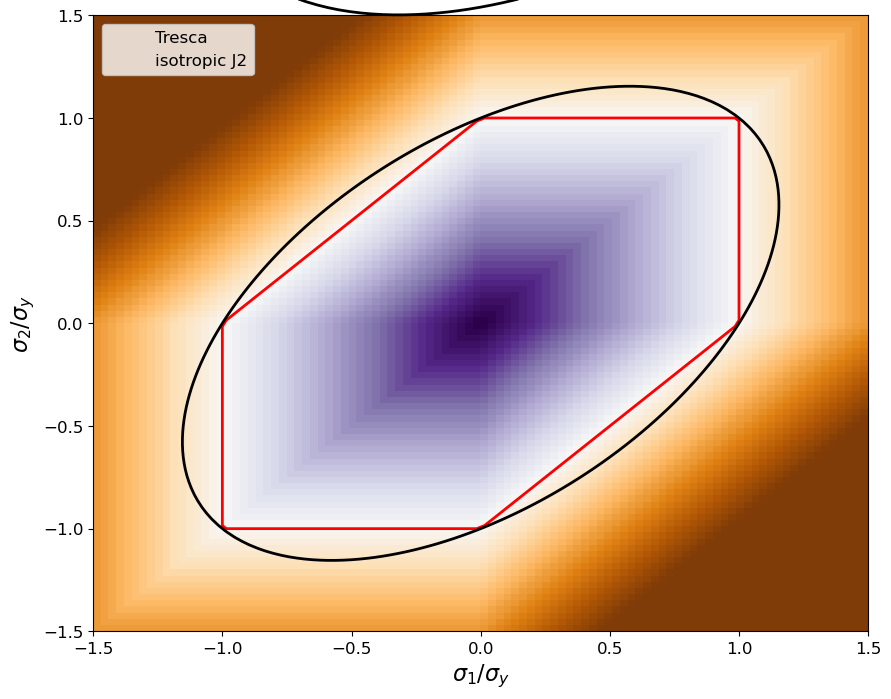

In [1]:
import pylabfea as FE
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from sklearn.metrics import r2_score
print('pyLabFEA version',FE.__version__)

#define two elastic-plastic materials with identical yield strength and elastic properties
E=200.e3
nu=0.3
sy = 150.
#Tresca-material as training model
mat_t = FE.Material(name='Tresca')
mat_t.elasticity(E=E, nu=nu)
mat_t.plasticity(sy=sy, tresca=True)

mat_iso = FE.Material(name='isotropic J2')
mat_iso.elasticity(E=E, nu=nu)
mat_iso.plasticity(sy=sy, sdim=3)
#isotropic material as basis for ML flow rule
mat_ml = FE.Material(name='ML flow rule')
mat_ml.elasticity(E=E, nu=nu)
mat_ml.plasticity(sy=sy, hill=[1.,1.,1.], drucker=0., khard=0., sdim=3)
print('Yield loci of anisotropic reference material and isotropic material')
ax = mat_t.plot_yield_locus(xstart=-1.5, xend=1.5, ref_mat=mat_iso, field=True)  #file='yield-locus-ref'

## Setup ML constitutive models

Here, the reference material `mat_t` with the Tresca yield function is used to produce training and test data for the machine learning algorithm. The yield function is represented as a step function such that Support Vector Classification (SVC) is used. 

## Cylindrical coordinates in deviatoric stress space
Since plastic deformation in most metals does not depend on hydrostatic stress components, the training process can be simplified by transforming the principal stresses from the representation as Cartesian (3D) vector $\sigma=(\sigma_1, \sigma_2, \sigma_3)$ in the principal stress space into a vector $s=(\sigma_{eq}, \theta, p)$ in the cylindrical coordinate system, with the equivalent stress $\sigma_{eq}$ representing the norm of the deviator of $\sigma$ and the polar angle $\theta$ lying in the deviatoric stress plane normal to the hydrostatic axis $p$. This coordinate transformation improves the efficiency of the training, because only 2D data for the equivalent stress and the polar angle $\theta$ need to be used as training features, whereas the hydrostatic component is disregarded.  The coordinate transformation is performed by introducing a complex-valued deviatoric stress
\begin{equation}
\sigma'_c = \pmb{\sigma}\cdot \pmb{a} + i\,\pmb{\sigma}\cdot \pmb{b} = \sqrt{2/3}\sigma_{eq}\; e^{i\theta}, 
\end{equation}
where $i$ is the imaginary unit, such that the polar angle is obtained as
\begin{equation}
\theta = \mathrm{arg}\, \sigma'_c = -i \, \ln \frac{\pmb{\sigma}\cdot \pmb{a} + 
         i\,\pmb{\sigma}\cdot \pmb{b}}
         {\sqrt{2/3}\sigma_{eq}} \,,
\end{equation}

where $a=(2,-1,-1)/\sqrt{6}$ (real axis) and $b=(0,1,-1)/\sqrt{2}$ (imaginary axis) are the unit vectors that span the deviatoric stress plane normal to the hydrostatic axis $c=(1,1,1)/\sqrt{3}$.

### Train ML yield function
In the following code segment, training and test data are generated and applied for training of the SVC, and the quality test of the result. To make the training process efficient, stress data for training and testing are already produced as purely deviatoric stress components, following the cylidrical stress vector definition given above. 
For the data and the trained ML yield function are plotted in the cylindrical stress space.

Plot theta vs. Tresca eqiv. stress curves for reference material


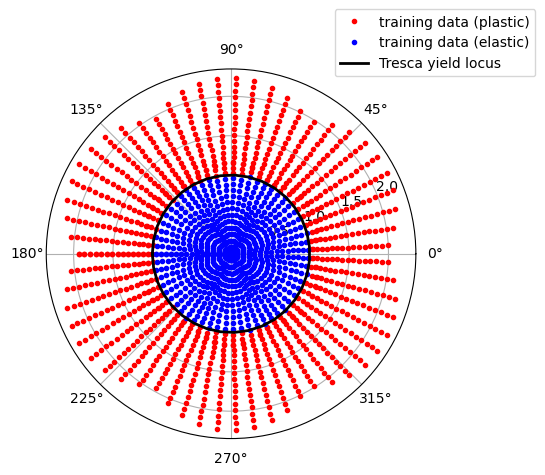

Converting principal stresses to cylindrical stresses for training

-------------------------

SVM classification fitted
-------------------------

SVC(C=50, gamma=9.0)
Training data points (only polar angle): 600 , Test data points: 60
Training set score: 99.19345238095238 %
Test set score: 99.03225806451613 %
r^2 on test data : 0.960800
Number of support vectors generated:  1689
Plot theta vs. J2 eqiv. stress curves for ML material


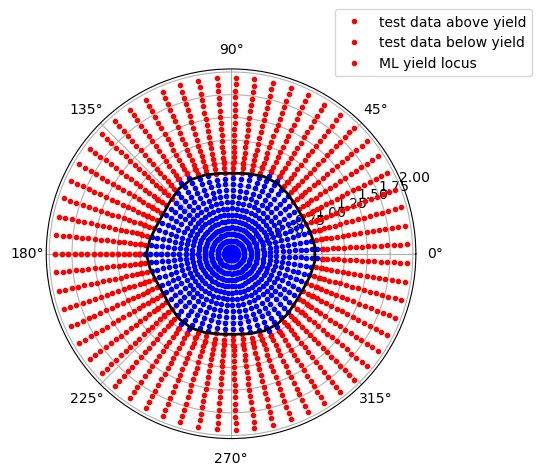

Plot of yield locus and training data in slices of 3D principle stress space
Plot of trained SVM classification with test data in 2D cylindrical stress space


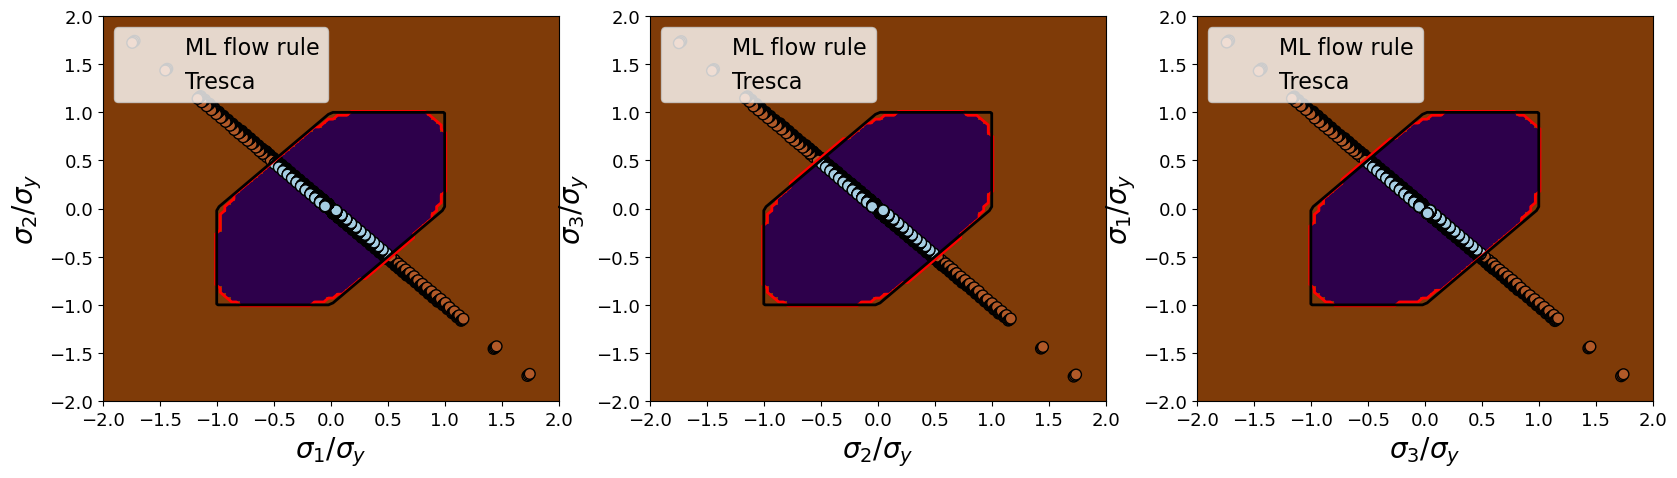

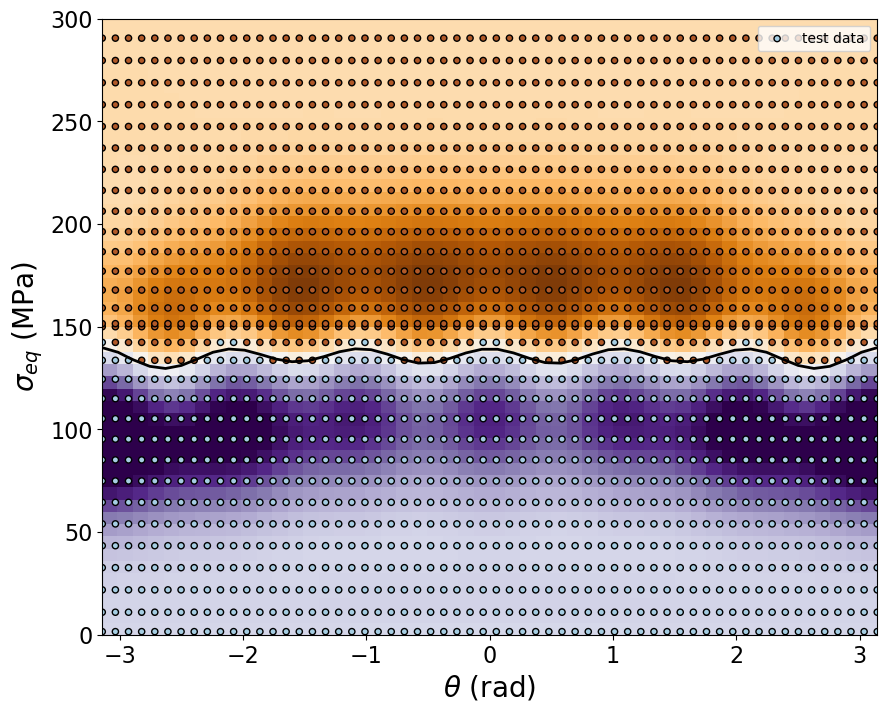

In [2]:
#Create training data in deviatoric stress space for components seq and theta
def create_data(N, mat, extend=False, rand=False):
    # create stresses along unit circle normal to hydrostatic axis
    if not rand:
        theta = np.linspace(-np.pi, np.pi, N)
    else:
        theta = 2.*(np.random.rand(N)-0.5)*np.pi
    sig = np.array([np.ones(N), theta]).T
    #expand stresses into elastic and plastic regimes
    #construct elastic data points
    xt = sig*np.array([0.01,1.])
    offs = 0.05
    nl = 15
    for i in range(nl):
        hh = np.array([1 - (i/nl)**1.1, 1.])  # down-scaling of equiv. stresses in elastic regime
        xt = np.append(xt, hh*sig, axis=0)
    #construct plastic data points
    offs = 1.01
    for i in range(nl):
        hh = np.array([offs + (i/nl)**1.1, 1.])
        xt = np.append(xt, hh*sig, axis=0)

    #add further training points far in plastic regime to avoid fallback of SVC decision fct. to zero
    if extend:
        for i in range(9):
            hh = np.array([i*0.5+2., 1.])
            xt = np.append(xt, hh*sig, axis=0)
    #result data for ML yield function (only sign is considered)
    x = FE.sp_cart(xt)
    y = np.sign(mat.calc_yf(x*mat.sy))
    return x,y 

#Training and testing data for ML yield function, based on reference Material mat_t
ndata = 600
ntest = np.maximum(20, int(ndata/10))
x_train, y_train = create_data(ndata, mat_t, extend=True) 
x_test, y_test = create_data(ntest, mat_t, rand=False)
x_train *= mat_t.sy
x_test *= mat_t.sy

print('Plot theta vs. Tresca eqiv. stress curves for reference material')
ind_e = np.nonzero(y_test<0.)[0]
ind_pl = np.nonzero(y_test>=0.)[0]
sc = FE.s_cyl(x_test, mat_t)  # convert princ. stresses into cylidrical coordinates
ax = plt.subplot(projection='polar')
l1 = ax.plot(sc[ind_pl,1],sc[ind_pl,0]/mat_t.sy,'.r')
l2 = ax.plot(sc[ind_e,1],sc[ind_e,0] /mat_t.sy,'.b')
#find norm of princ. stess vector lying on yield surface
theta = np.linspace(-np.pi,np.pi,36)
snorm = FE.sp_cart(np.array([mat_t.sy*np.ones(36)*np.sqrt(3/2), theta]).T)
x1 = fsolve(mat_t.find_yloc, np.ones(36), args=snorm, xtol=1.e-5)
sig = snorm*np.array([x1,x1,x1]).T
s_yld = mat_t.calc_seq(sig)
l3 = ax.plot(theta, s_yld/mat_t.sy, '-k', linewidth=2)
plt.legend([l1[0], l2[0], l3[0]], ['training data (plastic)','training data (elastic)','Tresca yield locus'], loc=(0.78,0.98))
#plt.savefig('polar-Hill.pdf', format='pdf', dpi=300)
plt.show()

#initialize and train SVC as ML yield function
#implement ML flow rule into mat_ml
train_sc, test_sc = mat_ml.setup_yf_SVM_3D(x_train, y_train, x_test=x_test, y_test=y_test, 
                                      C=50, gamma=9., fs=0.4, plot=False)  
y_pred_clf = mat_ml.calc_yf(x_test,pred=True)
r2_score_svm = r2_score(y_test, y_pred_clf)
print('\n-------------------------\n')
print('SVM classification fitted')
print('-------------------------\n')
print(mat_ml.svm_yf)
print("Training data points (only polar angle):", ndata,", Test data points:", ntest)
print("Training set score: {} %".format(train_sc))
print("Test set score: {} %".format(test_sc))
print("r^2 on test data : %f" % r2_score_svm)
print("Number of support vectors generated: ",len(mat_ml.svm_yf.support_vectors_))

print('Plot theta vs. J2 eqiv. stress curves for ML material')
ind1 = np.nonzero(y_test<0.)
ind2 = np.nonzero(y_test>=0.)
sc = FE.s_cyl(x_test) # convert princ. stresses into cylindrical coordinates
ax = plt.subplot(projection='polar')
l1 = ax.plot(sc[ind2,1],sc[ind2,0]/mat_ml.sy,'.r')
l2 = ax.plot(sc[ind1,1],sc[ind1,0]/mat_ml.sy,'.b')
#find norm of princ. stess vector lying on yield surface
theta = np.linspace(-np.pi,np.pi,36)
snorm = FE.sp_cart(np.array([mat_ml.sy*np.ones(36)*np.sqrt(3/2), theta]).T)
x1 = fsolve(mat_ml.find_yloc, 0.8*np.ones(36), args=snorm, xtol=1.e-5)
sig = snorm*np.array([x1,x1,x1]).T
s_yld = mat_ml.calc_seq(sig)
l3 = ax.plot(theta, s_yld/mat_ml.sy, '-k', linewidth=2)
plt.legend([l1[0], l1[0], l1[0]], ['test data above yield','test data below yield','ML yield locus'], loc=(0.78,0.98))
#plt.savefig('polar-J2.pdf', format='pdf', dpi=300)
plt.show()

print('Plot of yield locus and training data in slices of 3D principle stress space')
mat_ml.plot_yield_locus(field=True, data=x_train, ref_mat=mat_t, trange=3.e-2, 
                      axis1=[0,1,2], axis2=[1,2,0]) #, Nmesh=400, file='Tresca-yfct-slices')

print('Plot of trained SVM classification with test data in 2D cylindrical stress space')
xx, yy = np.meshgrid(np.linspace(-1, 1, 50),np.linspace(-1, 1, 50))
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
feat = np.c_[yy.ravel(),xx.ravel()]
Z = mat_ml.svm_yf.decision_function(feat)
hl = mat_ml.plot_data(Z, ax, xx*np.pi, (yy+1.)*mat_ml.sy, c='black')
sc = FE.s_cyl(x_test)
h1 = ax.scatter(sc[:,1], sc[:,0], s=20, c=y_test, cmap=plt.cm.Paired, edgecolors='k')
'''sv = np.array(mat_ml.svm_yf.support_vectors_)
csv = mat_ml.svm_yf.predict(sv)
sv[:,1] *= np.pi
sv[:,0] = (sv[:,0]+1.)*mat_ml.scale_seq
ind = np.nonzero(np.logical_and(sv[:,0]<2*mat_ml.sy, np.abs(sv[:,1])<=np.pi))[0]
h2 = ax.scatter(sv[ind,1], sv[ind,0], s=100, c=csv[ind], cmap=plt.cm.Paired, edgecolors='k')'''
ax.legend([h1], ['test data'],loc='upper right')
ax.set_xlabel(r'$\theta$ (rad)', fontsize=20)
ax.set_ylabel(r'$\sigma_{eq}$ (MPa)', fontsize=20)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
#fig.savefig('SVM-yield-fct_Tresca.pdf', format='pdf', dpi=300)
plt.show()

### Apply trained ML flow rule in FEA

After the successful training of the ML yield function, it can be applied directly in FEA. Its gradients of can be calculated directly from the coefficients and the support vectors resulting from the training process. The following code segment, demonstrates the application of the ML yield function in the pyLabFEA module. First, a model with two sections is generates, where section 1 is assigned to the reference material ``mat_t`` and section 2 is assigned to ``mat_ml`` with the ML yield function.

=== FEA with reference and ML material ===
Global strain:  [-0.0019  0.004  -0.0009  0.      0.      0.    ]
Element strain (ref):  [-0.0018  0.004  -0.0009  0.      0.      0.    ]
Element strain (ML):  [-0.0019  0.004  -0.0009  0.      0.      0.    ]
Global stress:  [  0.     144.8985   0.       0.       0.       0.    ]
Element stress (ref):  [  0. 150.   0.   0.   0.   0.]
Element stress (ML):  [  0.     139.7969   0.       0.       0.       0.    ]
Global plastic strain:  [-0.00164  0.00328 -0.00164  0.       0.       0.     ]
Plastic strain (ref):  [-0.00162  0.00325 -0.00163  0.       0.       0.     ]
Plastic strain (ML):  [-0.00165  0.0033  -0.00165  0.       0.       0.     ]
----------------------------
Material 1 (left block)  yield fct:  analytical  Gradient:  analytical, J2 isotropic, princ. stress
Material 2 (right block) yield fct:  ML_yf-decision-fct  Gradient:  gradient to ML_yf


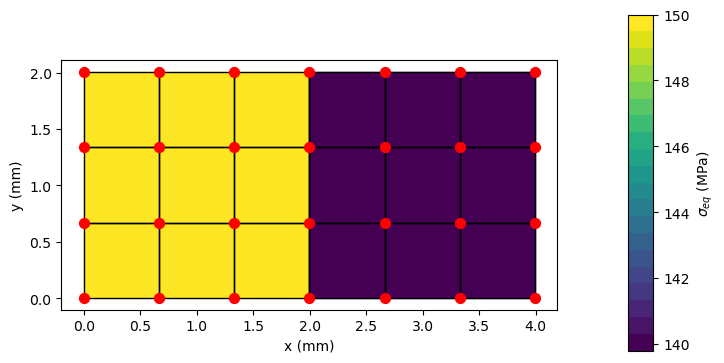

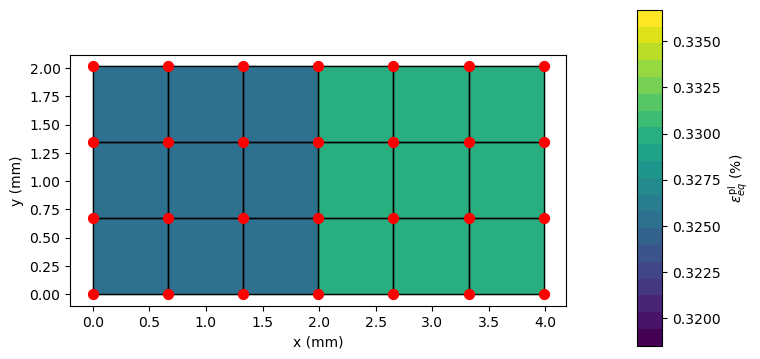

In [3]:
fem=FE.Model(dim=2,planestress=True)
fem.geom([2, 2], LY=2.)  # define sections in absolute lengths
print('==========================================')
print('=== FEA with reference and ML material ===')
print('==========================================')
fem.assign([mat_iso, mat_ml])  # create a model with trained ML-flow rule (mat_h) and reference material (mat3)
fem.bcleft(0.)
fem.bcbot(0.)
fem.bctop(0.004*fem.leny, 'disp')  # apply displacement at top nodes (uniax y-stress)
fem.mesh(NX=6, NY=3)
fem.solve()
fem.calc_global()
print('Global strain: ', np.round(fem.glob['eps'],decimals=4))
print('Element strain (ref): ', np.round(fem.element[0].eps,decimals=4))
print('Element strain (ML): ', np.round(fem.element[10].eps,decimals=4))
print('Global stress: ', np.round(fem.glob['sig'],decimals=4))
print('Element stress (ref): ', np.round(fem.element[0].sig,decimals=4))
print('Element stress (ML): ', np.round(fem.element[10].sig,decimals=4))
print('Global plastic strain: ', np.round(fem.glob['epl'],decimals=5))
print('Plastic strain (ref): ', np.round(fem.element[0].epl,decimals=5))
print('Plastic strain (ML): ', np.round(fem.element[10].epl,decimals=5))
print('----------------------------')
print('Material 1 (left block)  yield fct: ',mat_iso.msg['yield_fct'],' Gradient: ', mat_iso.msg['gradient'])
print('Material 2 (right block) yield fct: ',mat_ml.msg['yield_fct'], ' Gradient: ', mat_ml.msg['gradient'])

fem.plot('seq',mag=1)
fem.plot('peeq',mag=1)

Note that the J2 equivalent stresses in both materials are somewhat different althuogh under a uniaxial stress, the Tresca and J2 yield stresse should be the same. The difference results from the rounding-off of the sharp corners of the Tresca yield function by the ML yield function. The resulting plastic strains in both sections are still quite similar (bottom figure).

The second example applies the same four load cases under which the reference material has been characterized and compares the results.



====== Stress-Strain-Curves ======
---------------------------------------------------------
J2 yield stress under uniax-x loading: 139.277 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 139.136 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 139.306 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 129.657 MPa
---------------------------------------------------------


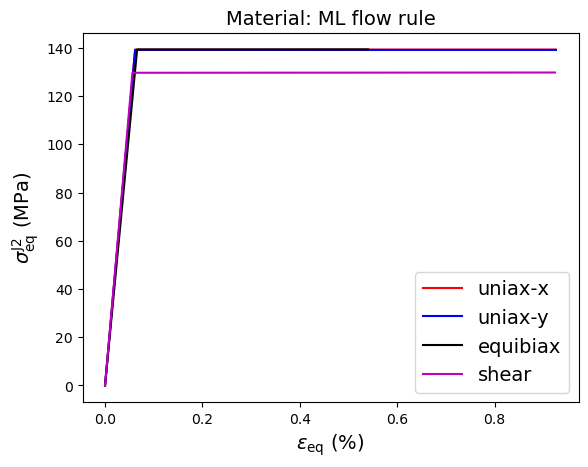

Yield loci and flow stresses in sig_1-sig_2 principle stress space


In [ ]:
print('\n\n====== Stress-Strain-Curves ======')
mat_ml.calc_properties(verb=False, eps=0.01, sigeps=True)
mat_ml.plot_stress_strain() 

print('Yield loci and flow stresses in sig_1-sig_2 principle stress space')
ax = mat_ml.plot_yield_locus(xstart=-1.5, xend=1.5, ref_mat=mat_t, iso=True, field=False, Nmesh=400, fontsize=26)
s=100
'ML material'
stx = mat_ml.sigeps['stx']['sig'][:,0:2]/mat_ml.sy
sty = mat_ml.sigeps['sty']['sig'][:,0:2]/mat_ml.sy
et2 = mat_ml.sigeps['et2']['sig'][:,0:2]/mat_ml.sy
ect = mat_ml.sigeps['ect']['sig'][:,0:2]/mat_ml.sy
ax.scatter(stx[1:,0],stx[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(sty[1:,0],sty[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(et2[1:,0],et2[1:,1],s=s, c='#f0ff00', edgecolors='k')
ax.scatter(ect[1:,0],ect[1:,1],s=s, c='#f0ff00', edgecolors='k')
plt.show()

sect = mat_t.calc_seq(mat_ml.sigeps['ect']['sig'][1,0:3])
set2 = mat_t.calc_seq(mat_ml.sigeps['et2']['sig'][1,0:3])
stx  = mat_t.calc_seq(mat_ml.sigeps['stx']['sig'][1,0:3])
sty  = mat_t.calc_seq(mat_ml.sigeps['sty']['sig'][1,0:3])
print('\n====== Tresca equivalent stress at yielding ======')
print('Nominal yield strength: ',mat_ml.sy,'MPa')
print('load case: ',mat_ml.prop['stx']['name'], '; Tresca equivalent stress: ',stx.round(decimals=2),'MPa')
print('load case: ',mat_ml.prop['sty']['name'], '; Tresca equivalent stress: ',sty.round(decimals=2),'MPa')
print('load case: ',mat_ml.prop['et2']['name'], '; Tresca equivalent stress: ',set2.round(decimals=2),'MPa')
print('load case: ',mat_ml.prop['ect']['name'], '; Tresca equivalent stress: ',sect.round(decimals=2),'MPa')
#plt.savefig('comp-yield-loci_Tresca.pdf', format='pdf', dpi=300)
plt.show()

It is seen that the flow stresses of the ML yield function stay on the yield locus, as it is expected for ideal plasticity.